## Componentes
    Gleydvan Macedo
    João Vítor Venceslau Coelho
    
## Professor
    Ivanovitch Medeiros Dantas da Silva
    
## Descrição II
Fazer um gráfico onde o eixo X são as médias dos alunos que cursaram a disciplina FMC I e o eixo Y as médias dos alunos que cursaram FMC II para toda a série histórica presente em dados.ufrn.br


In [1]:
# Importando alguns módulos importantes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Lendo os arquivos com os dados a serem analisados
matriculas_fmc1 = pd.read_csv("matriculas_fmc1.csv", sep = ";")
matriculas_fmc2 = pd.read_csv("matriculas_fmc2.csv", sep = ";")

In [3]:
# Função que simplifica o dataset informado
# Excluindo alguns dados não interessantes e deixando apenas as colunas interessantes
def simplifica_dataset ( data_set ):
    data_set = data_set[data_set["descricao"] != "EXCLUIDA"]
    data_set = data_set[data_set["descricao"] != "CANCELADO"]
    data_set = data_set[data_set["descricao"] != "TRANCADO"]
    data_set = data_set[data_set["descricao"] != "DESISTENCIA"]
    data_set = data_set[data_set["descricao"] != "INDEFERIDO"]
    data_set = data_set[["discente","descricao","unidade", "media_final"]]
    data_set = data_set.dropna()
    return data_set

# Simplificando os três datasets trabalhados
matriculas_fmc1 = simplifica_dataset( matriculas_fmc1 )
matriculas_fmc2 = simplifica_dataset( matriculas_fmc2 )

In [4]:
# Retirando informações repetidas baseando-se na unidade 1
fmc1 = matriculas_fmc1[matriculas_fmc1["unidade"] == 1]
fmc2 = matriculas_fmc2[matriculas_fmc2["unidade"] == 1]

# Removendo coluna que não é mais útil
fmc1 = fmc1.drop("unidade", axis = 1)
fmc2 = fmc2.drop("unidade", axis = 1)

In [5]:
# Removendo dados que não são interessantes no dataset de FMC1
fmc1 = fmc1[fmc1["descricao"] != "REPROVADO"]
fmc1 = fmc1[fmc1["descricao"] != "REPROVADO POR MÉDIA E POR FALTAS"]
fmc1 = fmc1[fmc1["descricao"] != "REPROVADO POR NOTA"]
fmc1 = fmc1[fmc1["descricao"] != "REPROVADO POR FALTAS"]

In [6]:
## Analisando quais os alunos que já cursaram as duas disciplinas

lista_discentes_em_comum = []
for discente in fmc1["discente"]:
    for discente2 in fmc2["discente"]:
        if ( discente == discente2 ):
            lista_discentes_em_comum.append( discente )
        
# Dataframe auxiliar para remover as duplicatas
aux = pd.DataFrame()
aux["discentes_em_comum"] = lista_discentes_em_comum
aux = aux.drop_duplicates()
aux = aux.reset_index()
aux = aux.drop("index", axis = 1)

# Criando uma lista baseada em FMC1 com os alunos que passaram em FMC1 e tentaram FMC2
lista_discentes_fmc1 = []
for discente in aux["discentes_em_comum"] :
    lista_discentes_fmc1.append( fmc1[fmc1["discente"] == discente ] )
    
# Criando uma lista baseada em FMC2 com os alunos que passaram em FMC1 e tentaram FMC2
lista_discentes_fmc2 = []
for discente in aux["discentes_em_comum"] :
    lista_discentes_fmc2.append( fmc2[fmc2["discente"] == discente ] )    

# Juntando os dados coletados nas duas listas em dois dataframes, um sobre FMC1 e outro sobre FMC2
data_frame1 = pd.concat( lista_discentes_fmc1, ignore_index=True )
data_frame2 = pd.concat( lista_discentes_fmc2, ignore_index=True )


In [7]:
# Resetando o index dos dois dataframes
data_frame1 = data_frame1.reset_index()
data_frame1 = data_frame1.drop("index", axis = 1)

data_frame2 = data_frame2.reset_index()
data_frame2 = data_frame2.drop("index", axis = 1)

In [8]:
# Função que remove os alunos que tentaram mais de uma vez passar em FMC2
# Mantém apenas a tentativa com a maior nota na média final
# Uma única chamada da função não consegue remover todas as repetições
# pois compara apenas com os dados vizinhos ( posterior ), logo se um aluno pagou várias é necessário]
# chamar a função novamente

# O motivo de comparar apenas com o valor posterior é diminuir a complexidade da função e agilizá-la,
# pois se compararmos com todos os elementos do dataset em busca das repetições e depois compararmos 
# qual é a maior média final, a complexidade ficaria muito grande e a função lenta, afinal são muitos dados...
def remove_repetidos_menor_nota( target ):
    linhas_apagar = []
    for linha in range(len(target)-1):
        if target.loc[linha]["discente"] == target.loc[linha+1]["discente"]:
            if target.loc[linha]["media_final"] > target.loc[linha+1]["media_final"]:
                linhas_apagar.append( linha+1 )
            else:
                linhas_apagar.append( linha )

    test = pd.DataFrame()
    test["apagar"] = linhas_apagar
    test = test.drop_duplicates()
    for i in test["apagar"]:
        target = target.drop(i)
        
    target = target.reset_index()
    target = target.drop("index", axis = 1)
    
    return target

In [9]:
# Chamando a função de remover repetidos no dataframe2 ( FMC2 )
data_frame2 = remove_repetidos_menor_nota( data_frame2 )
data_frame2 = remove_repetidos_menor_nota( data_frame2 )
data_frame2 = remove_repetidos_menor_nota( data_frame2 )

In [10]:
# Criando um dataframe contendo os valores coletados nos dois dataframes ( FMC1 e FMC2 )
# Com os dados já organizados e prontos para serem plotados
jointplot = pd.DataFrame()
jointplot["FMCI_Discente"] = data_frame1["discente"]
jointplot["FMCI_Media"] = data_frame1["media_final"]
jointplot["FMCII_Discente"] = data_frame2["discente"]
jointplot["FMCII_Media"] = data_frame2["media_final"]

In [11]:
# Realizando uma última verificação em busca de valores que não batem ( isto é discentes diferentes na mesma linha )
achei = []
for linha in range(len(jointplot)):
    if jointplot.loc[linha]["FMCI_Discente"] != jointplot.loc[linha]["FMCII_Discente"]:
        achei.append(linha)
# Imprimindo alunos em posição errada
achei

[]

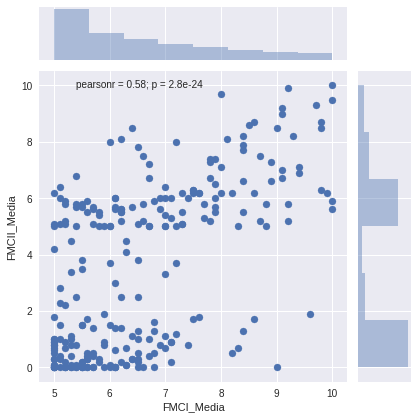

In [12]:
# Finalmente plotando o gráfico com as médias dos alunos de FMC1 que passaram e tentaram FMC2
sns.jointplot(x=jointplot["FMCI_Media"], y=jointplot["FMCII_Media"])
plt.show()